This notebook uses the images of the extracted faces from the real/fake videos in a folder layout:

Images/
    Train/
        Real/
        Fake/
    Val/
        Real/
        Fake/

I used EfficientNet (B3) [1] with pre-trained imagenet weights as the baseline model. EfficientNet can be installed via "pip install -U efficientnet". I chose this model for the baseline due to its efficiency in managing the size of the overall network and performance. The layers from the efficient net were frozen and new trainable layers were added for fine-tuning. There is scope for unfreezing some pre-trained layers for better performance. 

The data generators used a rescale function of 1./255 as a form of normalising the pixel values. Zoom, shear, and horizontal flips were added transforms as it is common for a wide range of videos to contain faces of varying distances / shear / and orientations from/to the camera. There is scope for these transforms to be fine-tuned for better performance. 

[1] Tan, Mingxing, and Quoc V. Le. "Efficientnet: Rethinking model scaling for convolutional neural networks." arXiv preprint arXiv:1905.11946 (2019).

In [2]:
'''
#Jupyter notebooks create hidden checkpoint folders which may skew the number of classes 
#detected by the data generators. In this event, use the following code to delete the hidden folders.

import shutil
shutil.rmtree("Images/Train/.ipynb_checkpoints")
shutil.rmtree("Images/Val/.ipynb_checkpoints")
'''

'\n#Jupyter notebooks create hidden checkpoint folders which may skew the number of classes \n#detected by the data generators. In this event, use the following code to delete the hidden folders.\n\nimport shutil\nshutil.rmtree("Images/Train/.ipynb_checkpoints")\nshutil.rmtree("Images/Val/.ipynb_checkpoints")\n'

In [3]:
from keras import applications
from efficientnet.keras import EfficientNetB5
from keras import callbacks
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from efficientnet.keras import center_crop_and_resize, preprocess_input
from keras import models, layers, optimizers
import keras

Using TensorFlow backend.


In [4]:
img_size = 224
input_shape = (img_size, img_size, 3)
batch_size = 16
num_train = 7911
num_val = 4719
class_mode = 'binary'
train_dir = 'Images/Train'
val_dir = 'Images/Val'

train_datagen = ImageDataGenerator( 
                rescale = 1. / 255, 
            horizontal_flip = True,
                rotation_range=0.2,
            brightness_range=(-0.2,0.2),
                fill_mode='nearest') 
  
test_datagen = ImageDataGenerator(rescale = 1. / 255) 
  
train_generator = train_datagen.flow_from_directory(
                                            train_dir, 
                    target_size =(img_size, img_size), 
                                batch_size = batch_size, 
                                class_mode = class_mode) 
  
validation_generator = test_datagen.flow_from_directory( 
                                                val_dir, 
                        target_size =(img_size, img_size), 
                                    batch_size = batch_size, 
                                    class_mode =class_mode) 

Found 7911 images belonging to 2 classes.
Found 4719 images belonging to 2 classes.


In [5]:
#Use transfer learning for the first set of layers
#Include pre-trained imagenet weights
eff_net = EfficientNetB5(
        weights='imagenet',
    input_shape=input_shape,
            include_top=False,
    classes=1
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
model = Sequential()
model.add(eff_net)

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 7, 7, 2048)        28513520  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100352)            401408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [7]:
print('This is the number of trainable layers '
      'before freezing eff_net base:', len(model.trainable_weights))

#Freeze the pretrained layers
eff_net.trainable = False

print('This is the number of trainable layers '
      'after freezing the eff_net base:', len(model.trainable_weights))

This is the number of trainable layers before freezing eff_net base: 512
This is the number of trainable layers after freezing the eff_net base: 8


In [8]:
check_point = keras.callbacks.ModelCheckpoint(
    filepath='model_saved.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

my_callbacks = [
    check_point,
    reduce_lr
]

In [9]:
model.compile(
            loss='binary_crossentropy',
        optimizer=optimizers.Adam(lr=1e-6),
                          metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
train_metrics = model.fit_generator(
    train_generator,
    epochs = 100,
    validation_data = validation_generator,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks = my_callbacks
)


Epoch 1/100
495/495 [==============================] - 54s 109ms/step - loss: 1.0061 - accuracy: 0.4992 - val_loss: 0.7404 - val_accuracy: 0.5005
Epoch 2/100
495/495 [==============================] - 49s 99ms/step - loss: 0.9491 - accuracy: 0.5251 - val_loss: 0.5222 - val_accuracy: 0.4976
Epoch 3/100
495/495 [==============================] - 49s 99ms/step - loss: 0.9176 - accuracy: 0.5290 - val_loss: 0.7242 - val_accuracy: 0.5077
Epoch 4/100
495/495 [==============================] - 49s 100ms/step - loss: 0.9339 - accuracy: 0.5291 - val_loss: 0.6618 - val_accuracy: 0.5393
Epoch 5/100
495/495 [==============================] - 49s 99ms/step - loss: 0.9130 - accuracy: 0.5386 - val_loss: 0.8903 - val_accuracy: 0.5349
Epoch 6/100
495/495 [==============================] - 49s 98ms/step - loss: 0.8738 - accuracy: 0.5501 - val_loss: 1.2560 - val_accuracy: 0.5546
Epoch 7/100
495/495 [==============================] - 49s 99ms/step - loss: 0.8755 - accuracy: 0.5521 - val_loss: 0.6698 - val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



495/495 [==============================] - 48s 98ms/step - loss: 0.8203 - accuracy: 0.5710 - val_loss: 0.7269 - val_accuracy: 0.5645
Epoch 54/100
495/495 [==============================] - 49s 99ms/step - loss: 0.8288 - accuracy: 0.5711 - val_loss: 0.5421 - val_accuracy: 0.5730
Epoch 55/100
495/495 [==============================] - 48s 98ms/step - loss: 0.8071 - accuracy: 0.5784 - val_loss: 0.6892 - val_accuracy: 0.5618
Epoch 56/100
495/495 [==============================] - 48s 98ms/step - loss: 0.8103 - accuracy: 0.5796 - val_loss: 0.7455 - val_accuracy: 0.5637
Epoch 57/100
495/495 [==============================] - 48s 98ms/step - loss: 0.8324 - accuracy: 0.5688 - val_loss: 0.5398 - val_accuracy: 0.5730
Epoch 57/100
Epoch 58/100
495/495 [==============================] - 49s 98ms/step - loss: 0.8239 - accuracy: 0.5703 - val_loss: 1.0311 - val_accuracy: 0.5624
Epoch 59/100
193/495 [==========>...................] - ETA: 18s - loss: 0.8208 - accuracy: 0.5602

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



495/495 [==============================] - 49s 98ms/step - loss: 0.8160 - accuracy: 0.5705 - val_loss: 0.9208 - val_accuracy: 0.5658
Epoch 86/100
495/495 [==============================] - 48s 97ms/step - loss: 0.8300 - accuracy: 0.5696 - val_loss: 0.7621 - val_accuracy: 0.5650
Epoch 87/100
495/495 [==============================] - 48s 97ms/step - loss: 0.7894 - accuracy: 0.5874 - val_loss: 0.9189 - val_accuracy: 0.5622
Epoch 88/100
495/495 [==============================] - 49s 98ms/step - loss: 0.7980 - accuracy: 0.5805 - val_loss: 0.9635 - val_accuracy: 0.5605
Epoch 89/100
495/495 [==============================] - 48s 98ms/step - loss: 0.7938 - accuracy: 0.5912 - val_loss: 0.5728 - val_accuracy: 0.5713
Epoch 89/100
Epoch 90/100
495/495 [==============================] - 48s 98ms/step - loss: 0.8377 - accuracy: 0.5626 - val_loss: 0.6157 - val_accuracy: 0.5605
Epoch 91/100
116/495 [======>.......................] - ETA: 23s - loss: 0.8302 - accuracy: 0.5544

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



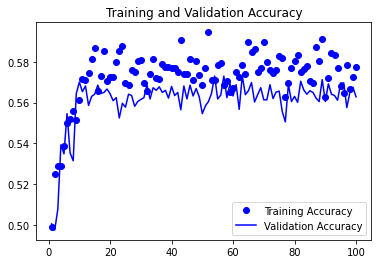

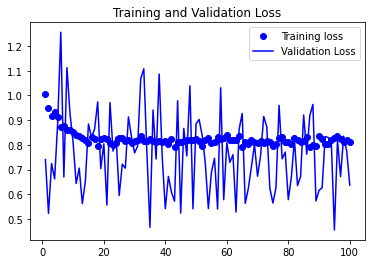

In [11]:
import matplotlib.pyplot as plt

acc = train_metrics.history['accuracy']
val_acc = train_metrics.history['val_accuracy']
loss = train_metrics.history['loss']
val_loss = train_metrics.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [12]:
#model.save_weights('modelhow m.h5') 